<a href="https://colab.research.google.com/github/norgaston/laboratorio2-mlbd/blob/main/Laboratorio_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Laboratorio 2 - Clasificador de canciones de Spotify**

ELEMENTOS DE APRENDIZAJE DE MÁQUINA Y BIG DATA

Carrera: T.U. TECNOLOGÍAS DE PROGRAMACIÓN SEDE PUNTA ALTA
Facultad: Facultad de la Micro, Pequeña y Mediana Empresa (UPSO)
Docente: Valentín Barco
Cuatrimestre/Año: 2° Cuatrimestre 2023

En este laboratorio, nos enfocaremos en un conjunto de datos repleto de atributos clave de
distintas canciones. La meta es establecer a través de herramientas de aprendizaje
automático, un clasificador que pueda predecir las inclinaciones musicales de un individuo y
predecir si disfrutará o no de una determinada canción.

**Integrantes del Grupo 12: Dolores Ponce y Gaston Ponce**

### **Bibliotecas necesarias**

In [1]:
# Importa las bibliotecas necesarias
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### **Carga y análisis exploratorio de los datos**

In [21]:
# Carga los datos en un DataFrame de Pandas
ruta = '/content/Canciones_Spotify.csv' # ruta desde donde voy a cargar el dataset
data = pd.read_csv(ruta, encoding='latin-1')
print("\nContenido del dataframe:\n\n",data)
# Elimino la primera columna (columna 0) utilizando el método drop
data.drop('Unnamed: 0', axis=1, inplace=True)
# Elimino si hay filas que contienen valores faltantes (NaN)
if data.isna().sum().any():
    print("\nHay NaN en los datos.")
    data = data.dropna()
else:
    print("\nNo hay NaN en los datos.")
print("\nValores únicos en cada columna del dataframe:\n\n", data.nunique(axis=0))
duplicadas = data[data.duplicated()]
# Eliminar las filas duplicadas me baja el rendimiento de los modelos
#cantidad_duplicadas = duplicadas.shape[0]
#if cantidad_duplicadas > 0:
#   print(f"\nSe encontraron {cantidad_duplicadas} filas duplicadas.")
    # Elimina las filas duplicadas
#    data = data.drop_duplicates()
#    print("Se eliminaron filas duplicadas.")
#else:
#    print("\nNo se encontraron filas duplicadas en el DataFrame.")
# Restablezco el índex
# data = data.reset_index(drop=True)
print("\nInformación del dataframe:\n")
data.info()


Contenido del dataframe:

       Unnamed: 0  acousticness  danceability  duration_ms  energy  \
0              0       0.01020         0.833       204600   0.434   
1              1       0.19900         0.743       326933   0.359   
2              2       0.03440         0.838       185707   0.412   
3              3       0.60400         0.494       199413   0.338   
4              4       0.18000         0.678       392893   0.561   
...          ...           ...           ...          ...     ...   
2012        2012       0.00106         0.584       274404   0.932   
2013        2013       0.08770         0.894       182182   0.892   
2014        2014       0.00857         0.637       207200   0.935   
2015        2015       0.00164         0.557       185600   0.992   
2016        2016       0.00281         0.446       204520   0.915   

      instrumentalness  key  liveness  loudness  mode  speechiness    tempo  \
0             0.021900    2    0.1650    -8.795     1       0.43

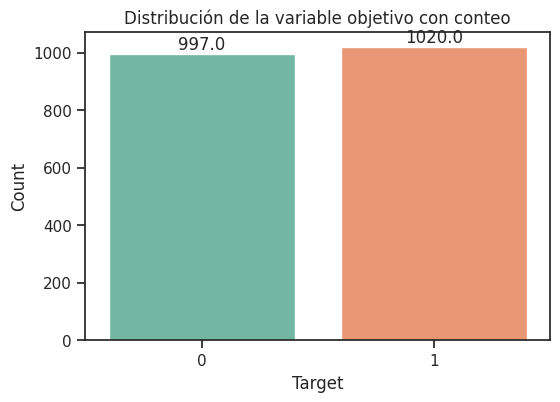

In [22]:
# Visualización de la distribución de la variable objetivo con el conteo
sns.set(style="ticks")
plt.figure(figsize=(6, 4))
ax = sns.countplot(x='target', data=data, palette='Set2')
# Agregar el conteo en el gráfico
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='bottom')
plt.xlabel("Target")
plt.ylabel("Count")
plt.title("Distribución de la variable objetivo con conteo")
plt.show()

Ambas clases tienen un número de muestras relativamente similar, por lo que es no necesario equilibrar las clases.

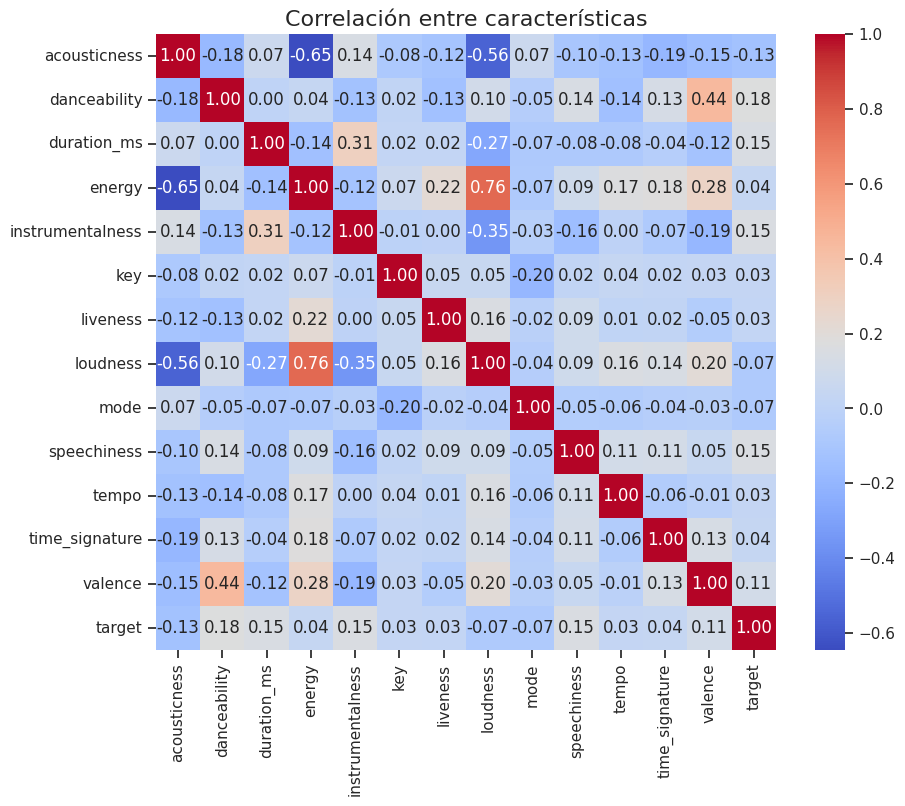

In [23]:
# Realizo un análisis de correlación entre las características
correlation_matrix = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlación entre características', fontsize=16)
plt.show()

Conclusiones generales que puedes obtener de estas correlaciones:

**Acousticness (Acústica):**Tiene una correlación negativa (-0.13) con "target". Esto sugiere que a medida que la acústica aumenta, la probabilidad de que la canción sea de la clase "target" disminuye ligeramente. Esto podría indicar que las canciones menos acústicas son más propensas a ser de la clase "target".

**Danceability (Bailable):**Tiene una correlación positiva (0.18) con "target". Esto significa que las canciones más bailables tienden a ser de la clase "target". Existe una relación positiva entre la bailable y la variable objetivo.

**Energy (Energía):**Tiene una correlación positiva (0.04) con "target". La energía de la canción no tiene una correlación fuerte con la variable objetivo, pero parece haber una ligera tendencia positiva.

**Instrumentalness (Instrumentalidad):**Tiene una correlación positiva (0.15) con "target". Las canciones más instrumentales tienden a ser de la clase "target". Esto podría ser una característica distintiva de la clase "target".

**Valence (Valencia):**Tiene una correlación positiva (0.11) con "target". Las canciones con una mayor valencia son ligeramente más propensas a ser de la clase "target".

**Danceability y Valence:**Danceability (bailabilidad) tiene una correlación positiva (0.44) con Valence (valencia), lo que sugiere que las canciones más bailables tienden a tener una mayor valencia.

**Loudness (Volumen):**Tiene una correlación positiva (0.20) con "target". Las canciones más fuertes tienden a ser de la clase "target".

**Speechiness (Hablado):**Tiene una correlación positiva (0.15) con "target". Las canciones con más elementos hablados tienden a ser de la clase "target".

### **Preparación de los Datos**

In [5]:
# Dividir los datos en conjuntos de entrenamiento y prueba
# X = data.drop(['target', 'song_title', 'artist', 'mode', 'key'], axis=1)
X = data.drop(['target', 'song_title', 'artist'], axis=1)
y = data['target']

# Escalar los datos (necesario en Support Vector Machine (SVM) y k-Nearest Neighbors (k-NN))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Realizar selección de características utilizando PCA
#num_components = 13  # Elige el número de componentes principales a retener
#pca = PCA(n_components=num_components)
#X_pca = pca.fit_transform(X_scaled)

# Crear DataFrames para las características seleccionadas después de PCA
#X_selected = pd.DataFrame(X_pca, columns=[f'PC{i}' for i in range(1, num_components + 1)])

### **Búsqueda de los mejores hiperparámetros para los modelos**

**Hiperparámetros para Random Forest**

In [6]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# Definir el modelo de Random Forest
rf_model = RandomForestClassifier(random_state=42)

# Definir la cuadrícula de hiperparámetros
param_grid = {
    'n_estimators': [100, 200, 300],  # Número de árboles en el bosque
    'max_depth': [10, 20, 30],  # Profundidad máxima de los árboles
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo
    'min_samples_leaf': [1, 2, 4],   # Número mínimo de muestras requeridas en cada hoja
}
# max_depth=20, max_features='log2', n_estimators=300, oob_score=True, ccp_alpha=0.0004
# Inicializar la búsqueda en cuadrícula
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')

# Realizar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo Random Forest
mejor_rf_model = grid_search.best_estimator_

# Evaluar el rendimiento del mejor modelo en los datos de prueba
predicciones_mejor_rf = mejor_rf_model.predict(X_test)
exactitud_mejor_rf = accuracy_score(y_test, predicciones_mejor_rf)
print("Exactitud del Mejor Random Forest en Pruebas:", exactitud_mejor_rf)

# Obtener los mejores hiperparámetros
print("Mejores Hiperparámetros Random Forest:", grid_search.best_params_)

Exactitud del Mejor Random Forest en Pruebas: 0.8118811881188119
Mejores Hiperparámetros Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


**Hiperparámetros para KNN**

In [7]:
# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# Definir los hiperparámetros que deseas ajustar
param_grid = {
    'n_neighbors': [3, 5, 7, 9],  # Valores para el número de vecinos
    'weights': ['uniform', 'distance'],  # Métodos para ponderar los vecinos
    'p': [1, 2],  # Distancia utilizada (1 para Manhattan, 2 para Euclidiana)
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # Algoritmos disponibles
    'leaf_size': [10, 20, 30],  # Tamaño de hoja (leaf size)
    'metric': ['minkowski', 'manhattan'],  # Métricas de distancia
}


# Crear el modelo KNN
knn = KNeighborsClassifier()

# Realizar búsqueda en cuadrícula con validación cruzada
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo y los mejores hiperparámetros
mejor_knn = grid_search.best_estimator_
mejores_hiperparametros = grid_search.best_params_

# Entrenar el modelo con los mejores hiperparámetros
mejor_knn.fit(X_train, y_train)

# Evaluar el rendimiento del modelo en los datos de prueba
predicciones_mejor_knn = mejor_knn.predict(X_test)
exactitud_mejor_knn = accuracy_score(y_test, predicciones_mejor_knn)

print("Mejores hiperparámetros KNN:", mejores_hiperparametros)
print("Exactitud del Mejor KNN en Pruebas:", exactitud_mejor_knn)

Mejores hiperparámetros KNN: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
Exactitud del Mejor KNN en Pruebas: 0.801980198019802


**Hiperparámetros para SVM**

In [8]:
# Definir el modelo SVM
svm = SVC()

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# Definir la cuadrícula de hiperparámetros
param_grid = {
    'C': [0.1, 1, 10],           # Parámetro de regularización
    'kernel': ['linear', 'rbf'],  # Tipo de kernel
    'gamma': ['scale', 'auto', 0.1, 1],  # Coeficiente del kernel (solo para 'rbf')
}

# Inicializar la búsqueda en cuadrícula
grid_search = GridSearchCV(svm, param_grid, cv=5, scoring='accuracy')

# Realizar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo SVM
mejor_svm = grid_search.best_estimator_

# Evaluar el rendimiento del mejor modelo en los datos de prueba
predicciones_mejor_svm = mejor_svm.predict(X_test)
exactitud_mejor_svm = accuracy_score(y_test, predicciones_mejor_svm)
print("Exactitud del Mejor SVM en Pruebas:", exactitud_mejor_svm)

# Obtener los mejores hiperparámetros
print("Mejores Hiperparámetros SVM:", grid_search.best_params_)

Exactitud del Mejor SVM en Pruebas: 0.8168316831683168
Mejores Hiperparámetros SVM: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


**Hiperparámetros para Decision Tree**

In [9]:
# Crear una instancia del modelo Decision Tree
decision_tree_model = DecisionTreeClassifier(random_state=42)

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.1, random_state=42)

# Definir la cuadrícula de hiperparámetros
param_grid = {
    'criterion': ['gini', 'entropy'],  # Criterio para la división
    'max_depth': [None, 10, 20, 30],   # Profundidad máxima del árbol
    'min_samples_split': [2, 5, 10],   # Número mínimo de muestras para dividir un nodo
    'min_samples_leaf': [1, 2, 4]     # Número mínimo de muestras en las hojas
}

# Inicializar la búsqueda en cuadrícula
grid_search = GridSearchCV(decision_tree_model, param_grid, cv=5, scoring='accuracy')

# Realizar la búsqueda en cuadrícula en los datos de entrenamiento
grid_search.fit(X_train, y_train)

# Obtener el mejor modelo Decision Tree
mejor_decision_tree_model = grid_search.best_estimator_

# Evaluar el rendimiento del mejor modelo en los datos de prueba
predicciones_mejor_decision_tree = mejor_decision_tree_model.predict(X_test)
exactitud_mejor_decision_tree = accuracy_score(y_test, predicciones_mejor_decision_tree)
print("Exactitud del Mejor Decision Tree en Pruebas:", exactitud_mejor_decision_tree)

# Obtener los mejores hiperparámetros
print("Mejores Hiperparámetros Decision Tree:", grid_search.best_params_)

Exactitud del Mejor Decision Tree en Pruebas: 0.7425742574257426
Mejores Hiperparámetros Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}


### **Entrenamiento de los Modelos de Clasificación**

In [10]:
# Dividir los datos seleccionados en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.10, random_state=42)

# Configurar hiperparámetros
# Mejores hiperparámetros KNN: {'algorithm': 'auto', 'leaf_size': 10, 'metric': 'minkowski', 'n_neighbors': 7, 'p': 1, 'weights': 'distance'}
knn_model = KNeighborsClassifier(algorithm ='auto', leaf_size = 10, metric ='minkowski', n_neighbors = 7, p = 1, weights = 'distance')
# Mejores Hiperparámetros SVM: {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}
svm_model = SVC(C=1, gamma=0.1, kernel='rbf')
# Mejores Hiperparámetros Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 10}
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2, min_samples_split=10)
# El modelo Naive Bayes no tiene hiperparámetros que requieran una búsqueda en cuadrícula (grid search)
naive_bayes_model = GaussianNB()
#Mejores Hiperparámetros Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
rf_model = RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=5, n_estimators=100)

# Entrenar modelos
knn_model.fit(X_train, y_train)
svm_model.fit(X_train, y_train)
decision_tree_model.fit(X_train, y_train)
naive_bayes_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Realizar predicciones
knn_predictions = knn_model.predict(X_test)
svm_predictions = svm_model.predict(X_test)
decision_tree_predictions = decision_tree_model.predict(X_test)
naive_bayes_predictions = naive_bayes_model.predict(X_test)
rf_predictions = rf_model.predict(X_test)

### **Funciones para graficar la matriz de confusión y la curva ROC para cada modelo**

In [11]:
# Función para graficar la matriz de confusión con valores
def plot_confusion_matrix_with_values(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix - {model_name}')
    plt.colorbar()
    classes = ['No Gusta', 'Gusta']
    for i in range(2):
        for j in range(2):
            plt.text(j, i, str(cm[i, j]), horizontalalignment='center', verticalalignment='center', color='black', fontsize=15)
    plt.xticks([0, 1], classes, rotation=45)
    plt.yticks([0, 1], classes)
    plt.tight_layout()
    plt.ylabel('Canciones Verdaderas')
    plt.xlabel('Canciones Predichas')

# Función para graficar la curva ROC y calcular el AUC
def plot_roc_curve(y_true, y_pred, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')

### **Evaluación de los modelos**

**K-Nearest Neighbors**

K-Nearest Neighbors:
[[96 13]
 [27 66]]
              precision    recall  f1-score   support

           0       0.78      0.88      0.83       109
           1       0.84      0.71      0.77        93

    accuracy                           0.80       202
   macro avg       0.81      0.80      0.80       202
weighted avg       0.81      0.80      0.80       202



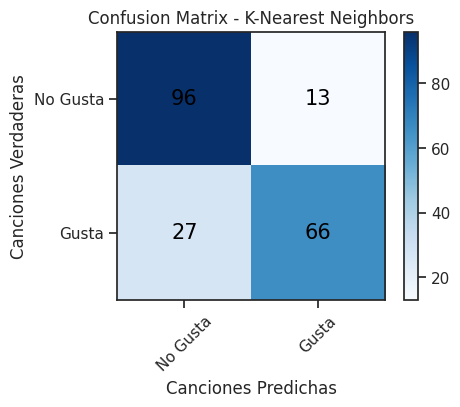

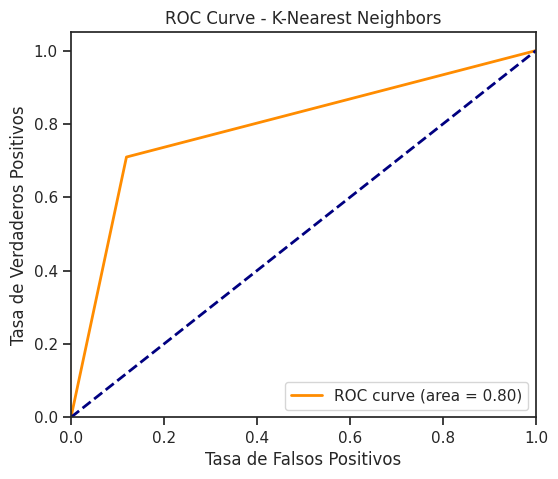

In [12]:
print("K-Nearest Neighbors:")
print(confusion_matrix(y_test, knn_predictions))
print(classification_report(y_test, knn_predictions))

plot_confusion_matrix_with_values(y_test, knn_predictions, 'K-Nearest Neighbors')
plt.show()
plot_roc_curve(y_test, knn_predictions, 'K-Nearest Neighbors')
plt.show()

**Support Vector Machine**

Support Vector Machine:
[[93 16]
 [21 72]]
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       109
           1       0.82      0.77      0.80        93

    accuracy                           0.82       202
   macro avg       0.82      0.81      0.81       202
weighted avg       0.82      0.82      0.82       202



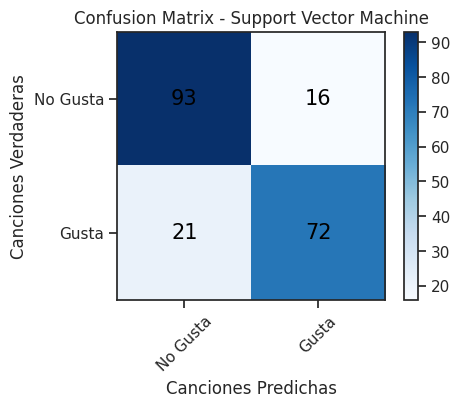

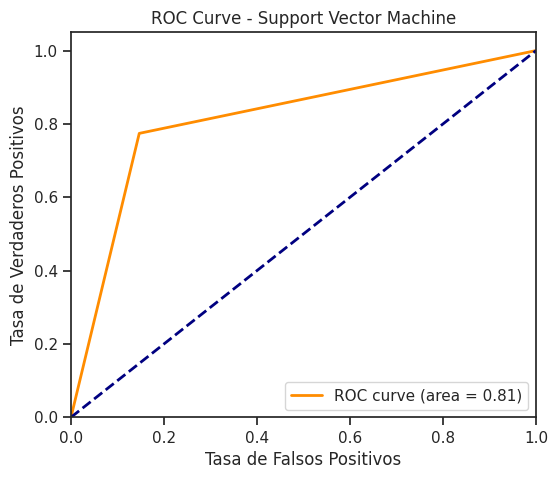

In [13]:
print("Support Vector Machine:")
print(confusion_matrix(y_test, svm_predictions))
print(classification_report(y_test, svm_predictions))

plot_confusion_matrix_with_values(y_test, svm_predictions, 'Support Vector Machine')
plt.show()
plot_roc_curve(y_test, svm_predictions, 'Support Vector Machine')
plt.show()

**Decision Tree**

Decision Tree:
[[88 21]
 [24 69]]
              precision    recall  f1-score   support

           0       0.79      0.81      0.80       109
           1       0.77      0.74      0.75        93

    accuracy                           0.78       202
   macro avg       0.78      0.77      0.78       202
weighted avg       0.78      0.78      0.78       202



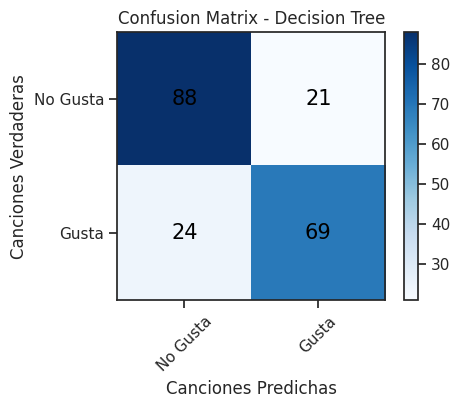

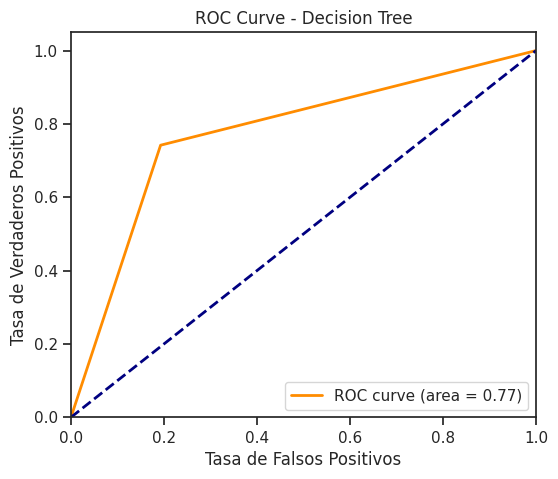

In [14]:
print("Decision Tree:")
print(confusion_matrix(y_test, decision_tree_predictions))
print(classification_report(y_test, decision_tree_predictions))

plot_confusion_matrix_with_values(y_test, decision_tree_predictions, 'Decision Tree')
plt.show()
plot_roc_curve(y_test, decision_tree_predictions, 'Decision Tree')
plt.show()

**Naive Bayes**

Naive Bayes:
[[68 41]
 [33 60]]
              precision    recall  f1-score   support

           0       0.67      0.62      0.65       109
           1       0.59      0.65      0.62        93

    accuracy                           0.63       202
   macro avg       0.63      0.63      0.63       202
weighted avg       0.64      0.63      0.63       202



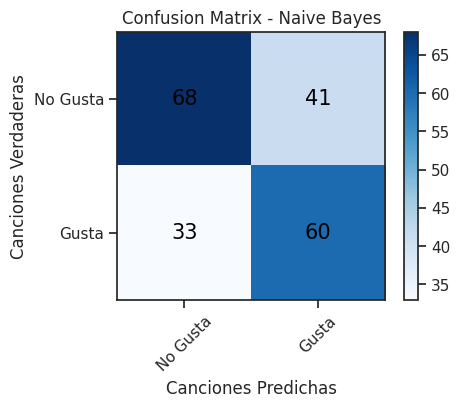

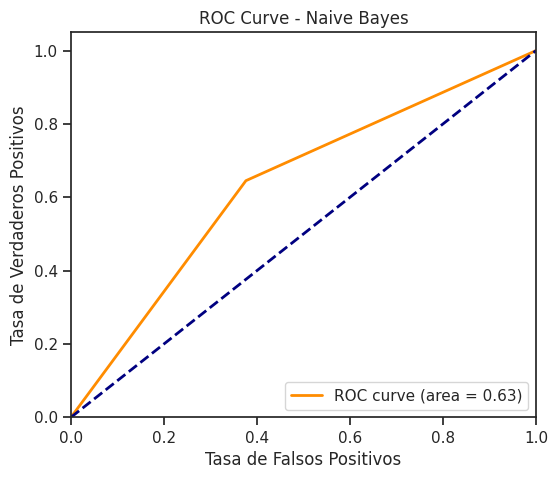

In [15]:
print("Naive Bayes:")
print(confusion_matrix(y_test, naive_bayes_predictions))
print(classification_report(y_test, naive_bayes_predictions))

plot_confusion_matrix_with_values(y_test, naive_bayes_predictions, 'Naive Bayes')
plt.show()
plot_roc_curve(y_test, naive_bayes_predictions, 'Naive Bayes')
plt.show()

**Random Forest**

Random Forest:
[[92 17]
 [17 76]]
              precision    recall  f1-score   support

           0       0.84      0.84      0.84       109
           1       0.82      0.82      0.82        93

    accuracy                           0.83       202
   macro avg       0.83      0.83      0.83       202
weighted avg       0.83      0.83      0.83       202



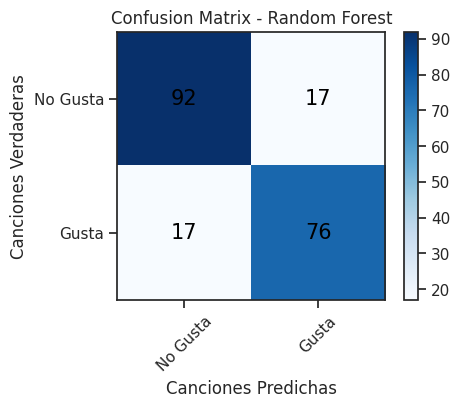

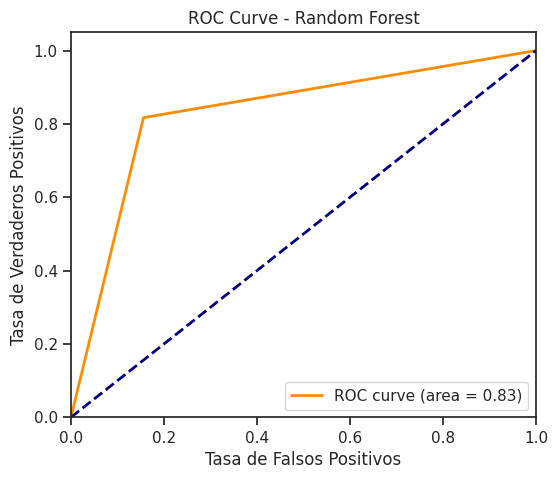

In [16]:
print("Random Forest:")
print(confusion_matrix(y_test, rf_predictions))
print(classification_report(y_test, rf_predictions))

plot_confusion_matrix_with_values(y_test, rf_predictions, 'Random Forest')
plt.show()
plot_roc_curve(y_test, rf_predictions, 'Random Forest')
plt.show()

**Votación Mayoritaria**

Ensamble (Votación Mayoritaria):
[[92 17]
 [21 72]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.83       109
           1       0.81      0.77      0.79        93

    accuracy                           0.81       202
   macro avg       0.81      0.81      0.81       202
weighted avg       0.81      0.81      0.81       202



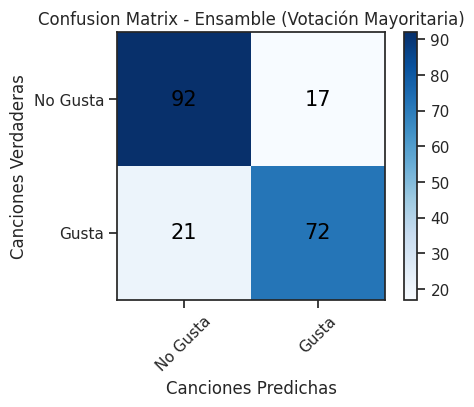

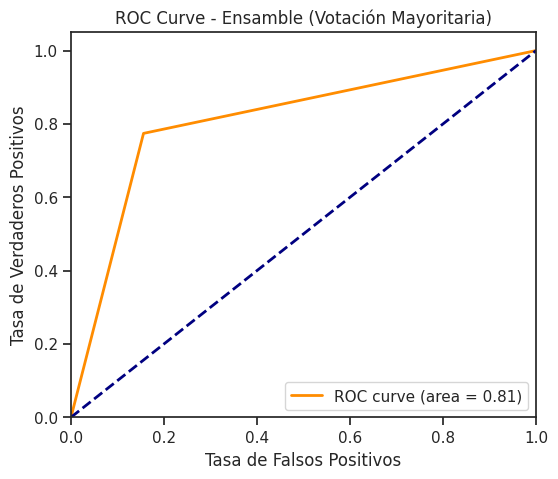

In [17]:
# Ensamble de modelos (Votación mayoritaria)
ensemble_model = VotingClassifier(estimators=[('KNN', knn_model), ('SVM', svm_model), ('DecisionTree', decision_tree_model), ('NaiveBayes', naive_bayes_model), ('RandomForest', rf_model)], voting='hard')
#ensemble_model = VotingClassifier(estimators=[('KNN', knn_model), ('SVM', svm_model), ('RandomForest', rf_model)], voting='hard')
ensemble_model.fit(X_train, y_train)
ensemble_predictions = ensemble_model.predict(X_test)

# Evaluar el ensamble
print("Ensamble (Votación Mayoritaria):")
print(confusion_matrix(y_test, ensemble_predictions))
print(classification_report(y_test, ensemble_predictions))

plot_confusion_matrix_with_values(y_test, ensemble_predictions, 'Ensamble (Votación Mayoritaria)')
plt.show()
plot_roc_curve(y_test, ensemble_predictions, 'Ensamble (Votación Mayoritaria)')
plt.show()

### **Comparación de las métricas resultantes de cada uno de los modelos** ###

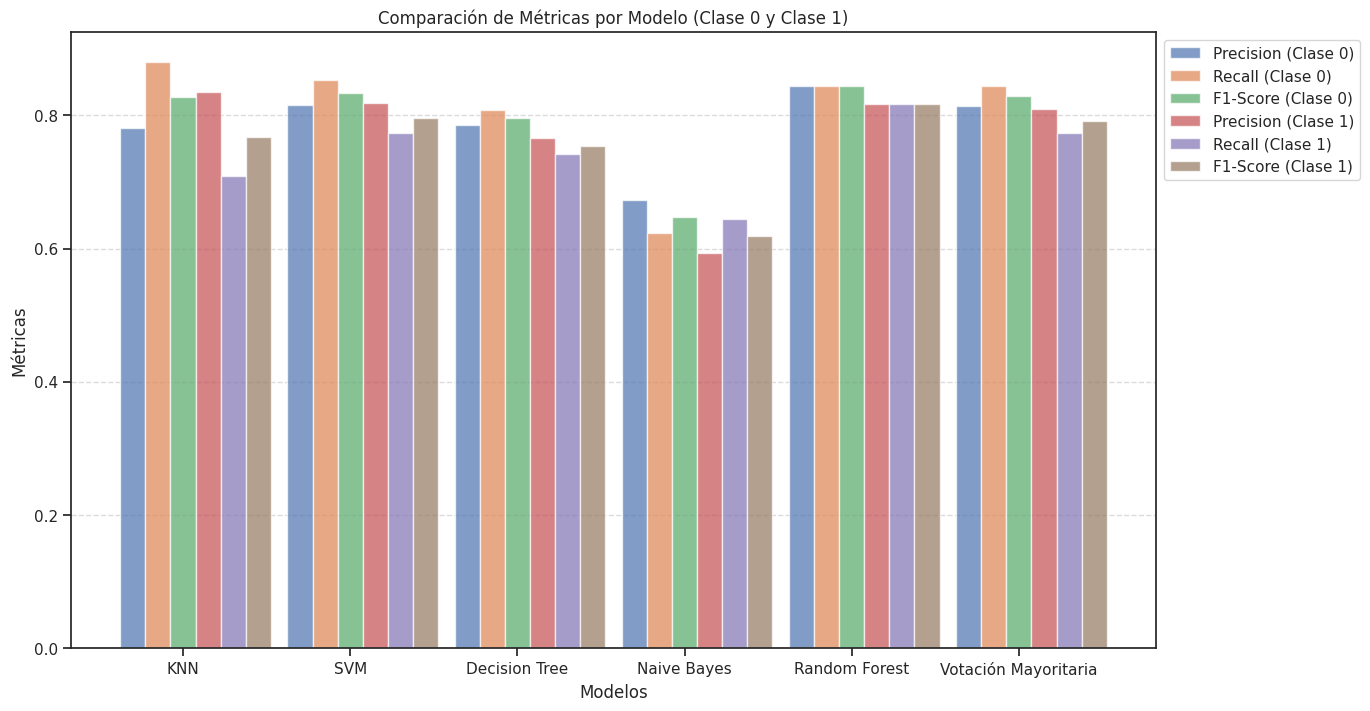

In [18]:
# Resultados de classification_report para cada modelo
report_knn = classification_report(y_test, knn_predictions, output_dict=True)
report_svm = classification_report(y_test, svm_predictions, output_dict=True)
report_decision_tree = classification_report(y_test, decision_tree_predictions, output_dict=True)
report_naive_bayes = classification_report(y_test, naive_bayes_predictions, output_dict=True)
report_rf = classification_report(y_test, rf_predictions, output_dict=True)
report_ensemble = classification_report(y_test, ensemble_predictions, output_dict=True)

# Métricas y modelos
metrics = ['precision', 'recall', 'f1-score']
models = ['KNN', 'SVM', 'Decision Tree', 'Naive Bayes', 'Random Forest', 'Votación Mayoritaria']

# Valores de métricas para ambas clases y modelos
precision_values_class_0 = [report_knn['0']['precision'], report_svm['0']['precision'], report_decision_tree['0']['precision'], report_naive_bayes['0']['precision'], report_rf['0']['precision'], report_ensemble['0']['precision']]
recall_values_class_0 = [report_knn['0']['recall'], report_svm['0']['recall'], report_decision_tree['0']['recall'], report_naive_bayes['0']['recall'], report_rf['0']['recall'], report_ensemble['0']['recall']]
f1_score_values_class_0 = [report_knn['0']['f1-score'], report_svm['0']['f1-score'], report_decision_tree['0']['f1-score'], report_naive_bayes['0']['f1-score'], report_rf['0']['f1-score'], report_ensemble['0']['f1-score']]

precision_values_class_1 = [report_knn['1']['precision'], report_svm['1']['precision'], report_decision_tree['1']['precision'], report_naive_bayes['1']['precision'], report_rf['1']['precision'], report_ensemble['1']['precision']]
recall_values_class_1 = [report_knn['1']['recall'], report_svm['1']['recall'], report_decision_tree['1']['recall'], report_naive_bayes['1']['recall'], report_rf['1']['recall'], report_ensemble['1']['recall']]
f1_score_values_class_1 = [report_knn['1']['f1-score'], report_svm['1']['f1-score'], report_decision_tree['1']['f1-score'], report_naive_bayes['1']['f1-score'], report_rf['1']['f1-score'], report_ensemble['1']['f1-score']]

# Configuración del gráfico
plt.figure(figsize=(14, 8))
bar_width = 0.15
index = range(len(models))

# Crear gráfico de barras para precisión (Clase 0)
plt.bar(index, precision_values_class_0, bar_width, label='Precision (Clase 0)', alpha=0.7)
# Crear gráfico de barras para recall (Clase 0)
plt.bar([i + bar_width for i in index], recall_values_class_0, bar_width, label='Recall (Clase 0)', alpha=0.7)
# Crear gráfico de barras para f1-score (Clase 0)
plt.bar([i + 2 * bar_width for i in index], f1_score_values_class_0, bar_width, label='F1-Score (Clase 0)', alpha=0.7)

# Crear gráfico de barras para precisión (Clase 1)
plt.bar([i + 3 * bar_width for i in index], precision_values_class_1, bar_width, label='Precision (Clase 1)', alpha=0.7)
# Crear gráfico de barras para recall (Clase 1)
plt.bar([i + 4 * bar_width for i in index], recall_values_class_1, bar_width, label='Recall (Clase 1)', alpha=0.7)
# Crear gráfico de barras para f1-score (Clase 1)
plt.bar([i + 5 * bar_width for i in index], f1_score_values_class_1, bar_width, label='F1-Score (Clase 1)', alpha=0.7)

plt.xlabel('Modelos')
plt.ylabel('Métricas')
plt.title('Comparación de Métricas por Modelo (Clase 0 y Clase 1)')

# Ajustar la posición de la leyenda fuera del gráfico
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.xticks([i + 2 * bar_width for i in index], models)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


In [19]:
# Crear un DataFrame de pandas con los resultados
data = {
    "Modelo": ["KNN", "SVM", "Decision Tree", "Naive Bayes", "Random Forest", "Votación Mayoritaria"],
    "Precisión (Clase 0)": [report_knn['0']['precision'], report_svm['0']['precision'], report_decision_tree['0']['precision'], report_naive_bayes['0']['precision'], report_rf['0']['precision'], report_ensemble['0']['precision']],
    "Recall (Clase 0)": [report_knn['0']['recall'], report_svm['0']['recall'], report_decision_tree['0']['recall'], report_naive_bayes['0']['recall'], report_rf['0']['recall'], report_ensemble['0']['recall']],
    "F1-Score (Clase 0)": [report_knn['0']['f1-score'], report_svm['0']['f1-score'], report_decision_tree['0']['f1-score'], report_naive_bayes['0']['f1-score'], report_rf['0']['f1-score'], report_ensemble['0']['f1-score']],
    "Precisión (Clase 1)": [report_knn['1']['precision'], report_svm['1']['precision'], report_decision_tree['1']['precision'], report_naive_bayes['1']['precision'], report_rf['1']['precision'], report_ensemble['1']['precision']],
    "Recall (Clase 1)": [report_knn['1']['recall'], report_svm['1']['recall'], report_decision_tree['1']['recall'], report_naive_bayes['1']['recall'], report_rf['1']['recall'], report_ensemble['1']['recall']],
    "F1-Score (Clase 1)": [report_knn['1']['f1-score'], report_svm['1']['f1-score'], report_decision_tree['1']['f1-score'], report_naive_bayes['1']['f1-score'], report_rf['1']['f1-score'], report_ensemble['1']['f1-score']],
    "Exactitud": [report_knn['accuracy'], report_svm['accuracy'], report_decision_tree['accuracy'], report_naive_bayes['accuracy'], report_rf['accuracy'], report_ensemble['accuracy']]
}
resultados = pd.DataFrame(data)

### **Conclusiones:**

En esta tabla, se puede ver claramente cómo cada modelo se desempeña en términos de precisión, recall, f1-score y exactitud para ambas clases.

---



In [20]:
resultados

,Modelo,Precisión (Clase 0),Recall (Clase 0),F1-Score (Clase 0),Precisión (Clase 1),Recall (Clase 1),F1-Score (Clase 1),Exactitud
0,KNN,0.780488,0.880734,0.827586,0.835443,0.709677,0.767442,0.801980
1,SVM,0.815789,0.853211,0.834081,0.818182,0.774194,0.795580,0.816832
2,Decision Tree,0.785714,0.807339,0.796380,0.766667,0.741935,0.754098,0.777228
3,Naive Bayes,0.673267,0.623853,0.647619,0.594059,0.645161,0.618557,0.633663
4,Random Forest,0.844037,0.844037,0.844037,0.817204,0.817204,0.817204,0.831683
5,Votación Mayoritaria,0.814159,0.844037,0.828829,0.808989,0.774194,0.791209,0.811881


## Conclusiones basadas en resultados de modelos de predicción

Los resultados de los modelos de predicción proporcionan una visión detallada de su rendimiento en la clasificación de canciones en dos clases: aquellas que le gustarán al usuario (Clase 1) y las que no (Clase 0). A continuación, se resumen las principales conclusiones basadas en estas métricas:

- **K-Nearest Neighbors (KNN):** El modelo KNN muestra un rendimiento sólido con alta precisión para ambas clases, lo que significa que es efectivo para predecir tanto las canciones que le gustarán como las que no. Además, alcanza un buen equilibrio entre precisión y recall, lo que se refleja en su puntuación F1 equilibrada. La exactitud general del modelo es alta, lo que lo convierte en una opción destacada.

- **Support Vector Machine (SVM):** SVM también ofrece resultados destacados, con alta precisión para ambas clases. Tiene un buen equilibrio entre precisión y recall, lo que se refleja en una alta puntuación F1. La exactitud general del modelo es elevada, lo que lo hace adecuado para predecir las preferencias del usuario.

- **Decision Tree:** Aunque el modelo de árbol de decisión ofrece buenos resultados, muestra una precisión ligeramente inferior en comparación con KNN y SVM. Aún así, es capaz de proporcionar predicciones razonables. La exactitud general del modelo es decente, lo que lo convierte en una opción viable.

- **Naive Bayes:** Naive Bayes presenta la precisión más baja para ambas clases en comparación con los otros modelos. Aunque es efectivo en ciertos contextos, sus resultados son menos sólidos en este caso, con una precisión y exactitud general más bajas.

- **Random Forest:** El modelo Random Forest se destaca por su equilibrio excepcional entre precisión y recall para ambas clases. Es una de las mejores opciones para predecir las preferencias del usuario, con una alta exactitud general.

- **Votación Mayoritaria:** La Votación Mayoritaria muestra un rendimiento sólido, con alta precisión y buen equilibrio entre precisión y recall para ambas clases. La exactitud general del modelo es alta.

En resumen, el modelo Random Forest sobresale con un equilibrio excepcional entre precisión y recall, convirtiéndolo en una elección sólida para predecir las preferencias del usuario. Sin embargo, la elección del modelo adecuado debe considerar otros factores, como la facilidad de interpretación, el costo computacional y la escalabilidad, así como la importancia de mantener un equilibrio entre las clases de la variable objetivo. Estos resultados son fundamentales para tomar decisiones informadas al seleccionar el modelo más adecuado para tu aplicación.





